# LCLS Archiver restore example

These examples show how single snapshots, and time series can be retreived from the archiver appliance.

Note that the times must always be in ISO 8601 format, UTC time (not local time). 


In [1]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

In [2]:
from lcls_live.archiver import lcls_archiver_restore
from lcls_live import data_dir
import json
import os

# This is the main function
?lcls_archiver_restore

Signature:
lcls_archiver_restore(
    pvlist,
    isotime='2018-08-11T10:40:00.000-07:00',
    verbose=True,
)
Docstring:
Returns a dict of {'pvname':val} given a list of pvnames, at a time in ISO 8601 format, using the EPICS Archiver Appliance:

https://slacmshankar.github.io/epicsarchiver_docs/userguide.html
File:      ~/Code/GitHub/lcls-live/lcls_live/archiver.py
Type:      function


## Optional: off-site setup

In [3]:
# Optional: 

# Open an SSH tunnel in a terminal like:
# ssh -D 8080 cmayes@rhel6-64.slac.stanford.edu 
# And then set:
os.environ['http_proxy']='socks5h://localhost:8080'
os.environ['HTTPS_PROXY']='socks5h://localhost:8080'
os.environ['ALL_PROXY']='socks5h://localhost:8080'

# Restore known PVs

In [4]:
pvlist = ['IRIS:LR20:130:MOTR_ANGLE', 
          'SOLN:IN20:121:BDES',
          'QUAD:IN20:121:BDES',
          'QUAD:IN20:122:BDES',
          'ACCL:IN20:300:L0A_PDES']

lcls_archiver_restore(pvlist, '2020-07-29T14:34:59.000000-07:00')

Requesting: http://lcls-archapp.slac.stanford.edu/retrieval/data/getDataAtTime?at=2020-07-29T14:34:59.000000-07:00&includeProxies=true


{'IRIS:LR20:130:MOTR_ANGLE': 220.6020050048828,
 'SOLN:IN20:121:BDES': 0.463,
 'QUAD:IN20:121:BDES': 0.0010584,
 'QUAD:IN20:122:BDES': 0.00055215,
 'ACCL:IN20:300:L0A_PDES': 0.0}

## Get snapshot from a large list

Same as above, but for processing large amounts of data

In [5]:
# Get list of PVs
fname = os.path.join(data_dir, 'classic/full_pvlist.json')
pvlist = json.load(open(fname))
pvlist[0:3]

['ACCL:IN20:350:FUDGE', 'ACCL:LI21:180:L1X_S_AV', 'ACCL:LI21:180:L1X_S_PV']

In [6]:
# Simple filename naming
def snapshot_filename(isotime):
    return  'epics_snapshot_'+isotime+'.json'

In [7]:
times = ['2018-03-06T15:21:15.000000-08:00']

lcls_archiver_restore(pvlist[0:10], times[0])

Requesting: http://lcls-archapp.slac.stanford.edu/retrieval/data/getDataAtTime?at=2018-03-06T15:21:15.000000-08:00&includeProxies=true


{'ACCL:IN20:350:FUDGE': 1.0039740050739583,
 'ACCL:LI21:180:L1X_S_AV': 20.01551950520014,
 'ACCL:LI21:180:L1X_S_PV': -159.9562692633193,
 'ACCL:LI21:1:FUDGE': 0.9916613729353901,
 'ACCL:LI21:1:L1S_S_PV': -26.12494033014282,
 'ACCL:LI22:1:FUDGE': 1.0191546491070553,
 'ACCL:LI24:100:KLY_PDES': 11.508785641181667,
 'ACCL:LI24:200:KLY_PDES': -75.12033429656984,
 'ACCL:LI24:300:KLY_PDES': -31.816975843257694,
 'ACCL:LI25:1:FUDGE': 1.0398871739006177}

In [8]:
%%time
# Make multiple files
root = './data/'
for t in times:
    newdata = lcls_archiver_restore(pvlist, t)
    fname = os.path.join(root, snapshot_filename(t))
    with open(fname, 'w') as f:
        f.write(json.dumps(newdata))
    print('Written:', fname)

Requesting: http://lcls-archapp.slac.stanford.edu/retrieval/data/getDataAtTime?at=2018-03-06T15:21:15.000000-08:00&includeProxies=true
Written: ./data/epics_snapshot_2018-03-06T15:21:15.000000-08:00.json
CPU times: user 15.9 ms, sys: 3.44 ms, total: 19.3 ms
Wall time: 3.4 s


# Get history of a single PV

In [9]:
from lcls_live.archiver import lcls_archiver_history, lcls_archiver_history_dataframe

t_start = '2020-07-29T14:30:00.000000-07:00'
t_end =   '2020-07-29T14:40:00.000000-07:00'

secs, vals = lcls_archiver_history('SOLN:IN20:121:BDES', start=t_start, end=t_end)

secs[0:5], vals[0:5]

http://lcls-archapp.slac.stanford.edu/retrieval/data/getData.json?pv=SOLN:IN20:121:BDES&from=2020-07-29T14:30:00.000000-07:00&to=2020-07-29T14:40:00.000000-07:00


([1596057797, 1596058247, 1596058247, 1596058252, 1596058292],
 [0.4664496,
  0.46369960000000005,
  0.46094960000000007,
  0.46369960000000005,
  0.4659])

More convenient, is to format this as a pandas dataframe. 

In [10]:
?lcls_archiver_history_dataframe

Signature: lcls_archiver_history_dataframe(pvname, **kwargs)
Docstring: Same as lcls_archiver_history, but returns a dataframe with the index as the time. 
File:      ~/Code/GitHub/lcls-live/lcls_live/archiver.py
Type:      function


In [11]:
df1 = lcls_archiver_history_dataframe('SOLN:IN20:121:BDES', start=t_start, end=t_end)
df1[0:5]

http://lcls-archapp.slac.stanford.edu/retrieval/data/getData.json?pv=SOLN:IN20:121:BDES&from=2020-07-29T14:30:00.000000-07:00&to=2020-07-29T14:40:00.000000-07:00


,SOLN:IN20:121:BDES
time,
2020-07-29 21:23:17,0.46645
2020-07-29 21:30:47,0.46370
2020-07-29 21:30:47,0.46095
2020-07-29 21:30:52,0.46370
2020-07-29 21:31:32,0.46590


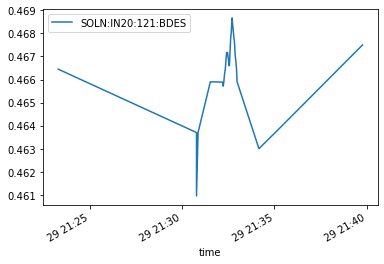

In [12]:
# Pandas has convenient plotting
df1.plot()

In [13]:
# Try another PV. Note that this one only has one point, and is at a very different time
df2 = lcls_archiver_history_dataframe('YAGS:IN20:241:XRMS', start=t_start, end=t_end)
df2

http://lcls-archapp.slac.stanford.edu/retrieval/data/getData.json?pv=YAGS:IN20:241:XRMS&from=2020-07-29T14:30:00.000000-07:00&to=2020-07-29T14:40:00.000000-07:00


,YAGS:IN20:241:XRMS
time,
2020-07-20 03:31:57,419.030786
